# Modelling via scikit-learn

This notebook performs model fitting and evaluating on hold out areas, using models from scikit-learn.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import sqrt
import pathlib
import os
from sklearn.externals import joblib
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.reset_option('^display')

# ignore warnings
import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../utils')
import modelutils
from settings import *

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## File Locations

In [2]:
dirs = [model_dir, scaler_dir, preds_dir]
for dir_ in dirs:
    with pathlib.Path(dir_) as path:
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)

## Load Data

In [ ]:
!gsutil cp gs://immap-wash-training/training/20200830_*.csv {data_dir}

features = satellite_features + poi_features
raw1 = pd.read_csv(data_dir + '20200830_urban_dataset.csv')
raw2 = pd.read_csv(data_dir + '20200830_rural_dataset.csv')
raw1['urbanity'] = 'u'
raw2['urbanity'] = 'r'
df = (pd.concat([raw1, raw2], axis = 0)
      .query("aridity_cgiarv2 > -2e9") # 28 rows
      .query("elevation > 0") # 2 rows
      .query("nearest_waterway > 0") # 255 rows
       .dropna(subset = indicators + satellite_features + poi_features + ['urbanity', 'id', 'adm1_name'])
      .reset_index(drop = True)
     )
print(raw1.shape)
print(raw2.shape)
print(df.shape)

df.to_csv(data_dir + '20200830_dataset.csv')

!gsutil cp {data_dir}20200830_dataset.csv gs://immap-wash-training/training/

## Check nulls and outliers

Total rows: 57143
Variables with missing values:
Empty DataFrame
Columns: [count, mean, std, min, max]
Index: []


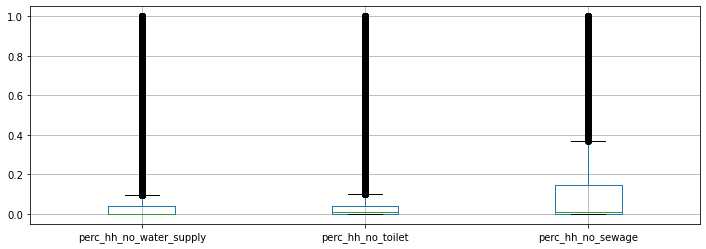

In [7]:
check_nulls_and_outliers(df, columns = indicators)

Total rows: 57143
Variables with missing values:
Empty DataFrame
Columns: [count, mean, std, min, max]
Index: []


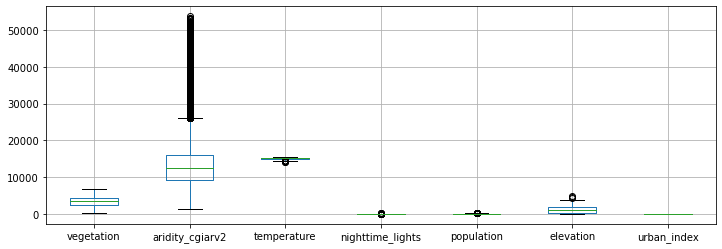

In [12]:
check_nulls_and_outliers(df, columns = satellite_features)

Total rows: 57143
Variables with missing values:
Empty DataFrame
Columns: [count, mean, std, min, max]
Index: []


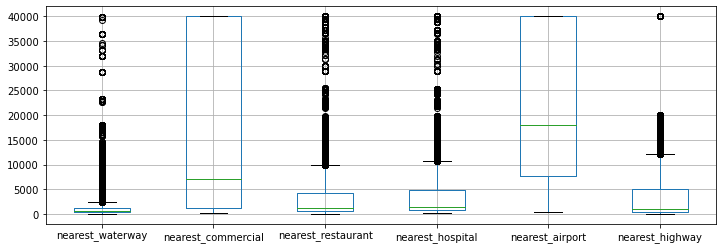

In [13]:
check_nulls_and_outliers(df, columns = poi_features)

## Count rows with WASH value 0 (has access)

In [46]:
for urb_ in ['u', 'r']:
    print(f"Processing for urbanity = '{urb_}'")
    for indicator in indicators:
        print(indicator)
        print(sum(df.query(f"urbanity == '{urb_}'")[indicator]==0)/df.shape[0])

Processing for urbanity = 'u'
perc_hh_no_water_supply
0.43896890257774357
perc_hh_no_toilet
0.24186689533276168
perc_hh_no_sewage
0.3130742173144567
Processing for urbanity = 'r'
perc_hh_no_water_supply
0.03722240694398264
perc_hh_no_toilet
0.03307491731270672
perc_hh_no_sewage
0.03307491731270672


## Fit, Predict and Evaluate Models Using 5-fold Cross Validation
Trains a random forest model to predict each of the 3 WASH indicators, setting random 20% of the data (whichever the area) as test data and everything else as training data. The train-test split is done for 5 different folds.

### Using Both Urban and Rural Dataset

In [19]:
# clf = RandomForestRegressor(random_state=42)

# res = fit_with_randomsplit(df, clf, features, indicators, scale = True, n_splits = 5, prefix = 'all')
res = pd.read_csv(data_dir + 'all_randomsplit_results.csv')
average_results(res, iterate_over = 'split_id', prefix = 'all')

Access to water
correlation    0.743460
r2             0.552808
rmse           0.136566
dtype: float64
Access to toilet
correlation    0.736653
r2             0.542765
rmse           0.123098
dtype: float64
Access to sewage
correlation    0.791600
r2             0.626643
rmse           0.176313
dtype: float64


In [9]:
pearsonr(res['y_true'], res['y_pred'])[0]**2

0.6007718215356018

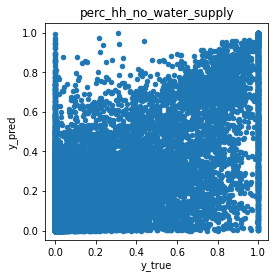

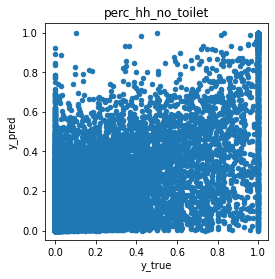

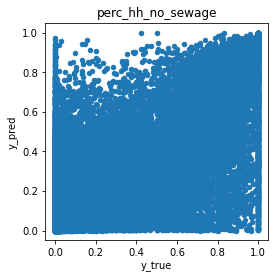

In [27]:
for indicator in indicators:
    (res.query(f"indicator == '{indicator}'")
     .plot(x = 'y_true', y = 'y_pred', figsize = (4,4), kind = 'scatter', title = indicator))

### Using Urban Only

In [20]:
# sub = df.query("urbanity == 'u'").reset_index(drop = True)
# print(sub.shape)
# clf = RandomForestRegressor(random_state=42)

# res = fit_with_randomsplit(sub, clf, features, indicators, scale = True, n_splits = 5, prefix = 'urban')
res = pd.read_csv(data_dir + 'urban_randomsplit_results.csv')
average_results(res, iterate_over = 'split_id', prefix = 'urban')

Access to water
correlation    0.768037
r2             0.589947
rmse           0.110818
dtype: float64
Access to toilet
correlation    0.594963
r2             0.354199
rmse           0.090634
dtype: float64
Access to sewage
correlation    0.797290
r2             0.635692
rmse           0.160999
dtype: float64


In [12]:
pearsonr(res['y_true'], res['y_pred'])[0]**2

0.6086103014811824

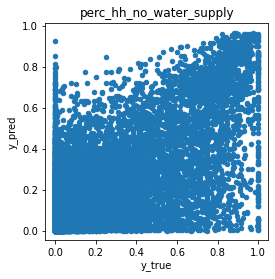

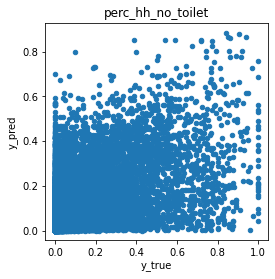

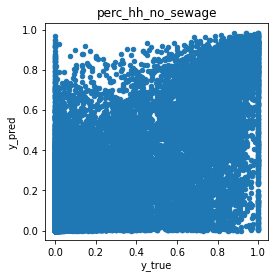

In [29]:
for indicator in indicators:
    (res.query(f"indicator == '{indicator}'")
     .plot(x = 'y_true', y = 'y_pred', figsize = (4,4), kind = 'scatter', title = indicator))

### Using Rural Only

In [18]:
# sub = df.query("urbanity == 'r'").reset_index(drop = True)
# print(sub.shape)
# clf = RandomForestRegressor(random_state=42)

# res = fit_with_randomsplit(sub, clf, features, indicators, scale = True, n_splits = 5, prefix = 'rural')
res = pd.read_csv(data_dir + 'rural_randomsplit_results.csv')
average_results(res, iterate_over = 'split_id', prefix = 'rural')

Access to water
correlation    0.600355
r2             0.361444
rmse           0.300899
dtype: float64
Access to toilet
correlation    0.734954
r2             0.540172
rmse           0.283941
dtype: float64
Access to sewage
correlation    0.734954
r2             0.540172
rmse           0.283941
dtype: float64


In [15]:
pearsonr(res['y_true'], res['y_pred'])[0]**2

0.49521965030378345

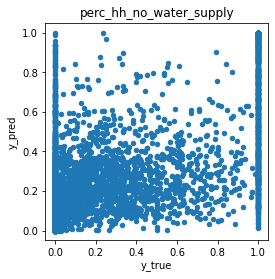

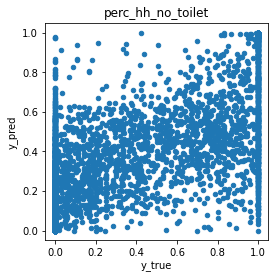

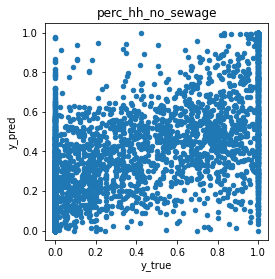

In [34]:
for indicator in indicators:
    (res.query(f"indicator == '{indicator}'")
     .plot(x = 'y_true', y = 'y_pred', figsize = (4,4), kind = 'scatter', title = indicator))